In [8]:
from src import MACGenerator, UDP_TX, SlidingBook
import src.TX as TX

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import socket
import struct
import time
import json
import cv2

import sys

sys.path.append('..')
import utils.utils as utils


exp = utils.Load_Experiments("../Examples/Xs.pkl")

###### IP, PORRT ######
IP = "10.42.0.15"
PORT = 23422
#######################



#### parameters that needs to be exhanged between the sender and the receiver #####
param ={}

#traditional MAC
X = np.eye(10)
Y = np.eye(10)

param['X'] = X.tolist()
param['Y'] = Y.tolist()
param['KEY'] = "key"
param['DIGESTMOD'] = 'sha384'
param['PAYLOAD_SIZE_BYTE']= 64
param['QUALITY'] = 70   # param['QUALITY'] of the JPEG compression
param['ATTACK_PROBABILITY'] = 0.01  # probability of the attack
param['DURATION'] = 10  # running time of the sender in seconds
####################################################################################




# send the parameters to the receiver and the time.time() to synchronize the sender and the receiver
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((IP, PORT))
    s.sendall(json.dumps(param).encode())
    time.sleep(.1)
    data = time.time()
    data = struct.pack('d', data)
    s.send(data)




# Capture video from the default camera
cap = cv2.VideoCapture(0) 
# Define the compression parameters for Progressive JPEG
compression_params = [cv2.IMWRITE_JPEG_PROGRESSIVE, 1, cv2.IMWRITE_JPEG_QUALITY, param['QUALITY']]
## counting the number of frames per second

start_time = time.time()
runTime_cnt = time.time()
frame_counter = 0
average_tx_size = 0
while True:
    ret, frame = cap.read()
    # Encode the image to JPEG format in memory
    success, encoded_frame = cv2.imencode('.jpg', frame, compression_params)
    data = encoded_frame.tobytes()
    average_tx_size+=len(data)//1000

    #############################  TX  ########################################
    buffer = SlidingBook(num_pages=40, page_size=len(param['X']))
    page_processor = MACGenerator(X = param['X'], Y = param['Y'], secret_key=param['KEY'].encode(), digestmod=param['DIGESTMOD'])
    udp_tx = UDP_TX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte = param['PAYLOAD_SIZE_BYTE'])
    pages = udp_tx.segment_to_pages(data)
    udp_tx.transmit(pages, param['ATTACK_PROBABILITY'])
    ###########################################################################

    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

    # print the frame rate
    frame_counter += 1
    if time.time() - start_time >= 1:
        print("frame per second: ", frame_counter, "fps ,data rate: ", average_tx_size, "KB/s")
        frame_counter = 0
        start_time = time.time()
        average_tx_size = 0
    if time.time() - runTime_cnt >= param['DURATION']:
        break
cv2.destroyAllWindows()
cap.release()

KeyboardInterrupt: 

In [9]:

exp = utils.Load_Experiments("../Examples/Xs.pkl")


def find_augmenting_path(X, u, match_from_V2_to_V1, visited):
    for v in range(len(X[0])):
        if X[u][v] == 1 and not visited[v]:
            visited[v] = True
            if match_from_V2_to_V1[v] == -1 or find_augmenting_path(X, match_from_V2_to_V1[v], match_from_V2_to_V1, visited):
                match_from_V2_to_V1[v] = u
                return True
    return False


def Get_Y(X):
    # Number of vertices in V1 and V2
    V1_size = len(X)
    V2_size = len(X[0])

    # Array to store the match from V2 to V1, initialized to -1 (no match)
    match_from_V2_to_V1 = [-1] * V2_size

    # Try to find a match for every node in V1
    for u in range(V1_size):
        visited = [False] * V2_size  # Keeps track of visited nodes in V2 for each attempt
        find_augmenting_path(X, u, match_from_V2_to_V1, visited)

    # Check if we found a right-perfect matching
    if all(x != -1 for x in match_from_V2_to_V1):
        # Create the result matrix Y
        Y = np.zeros_like(X)
        for j in range(V2_size):
            Y[match_from_V2_to_V1[j]][j] = 1
        return Y
    else:
        return None

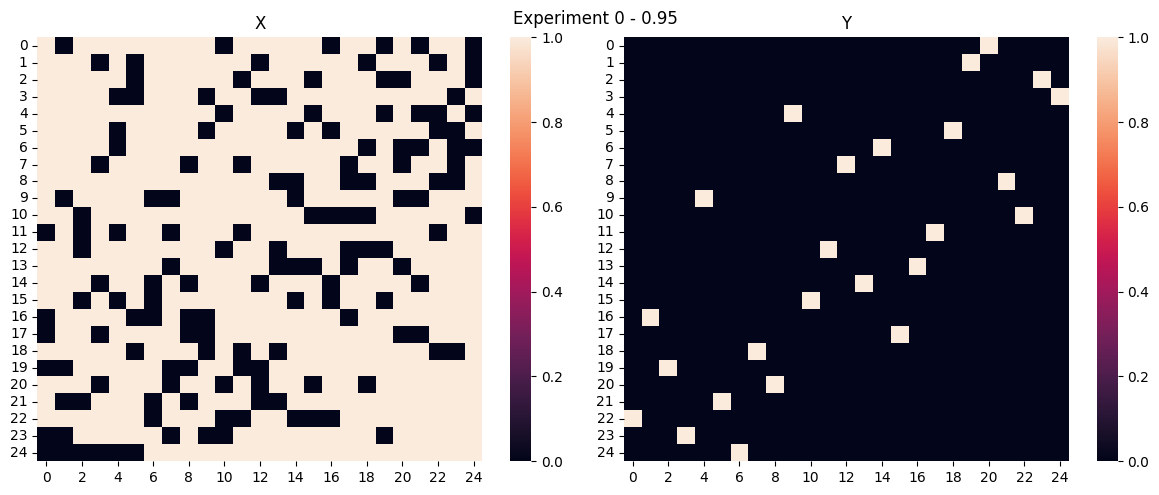

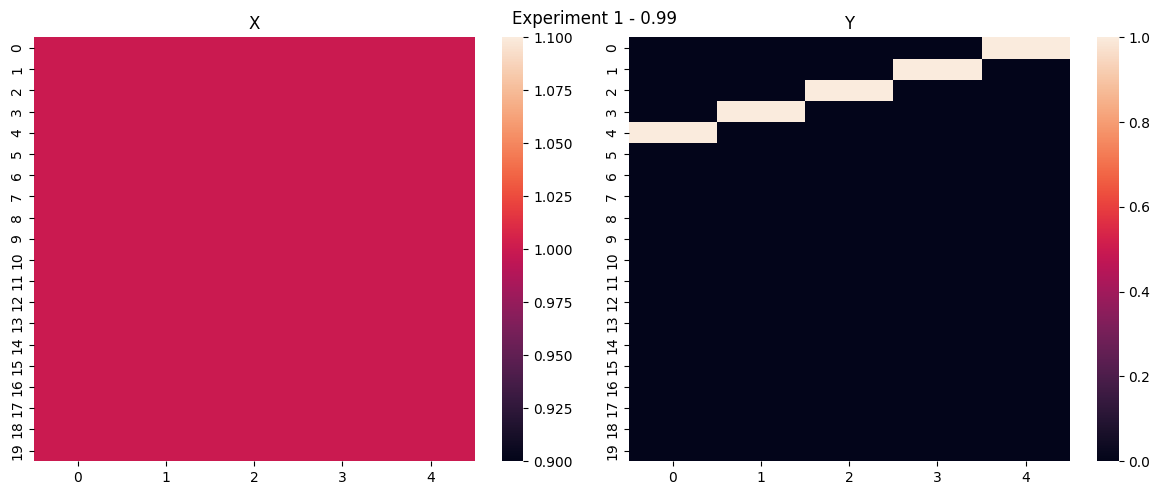

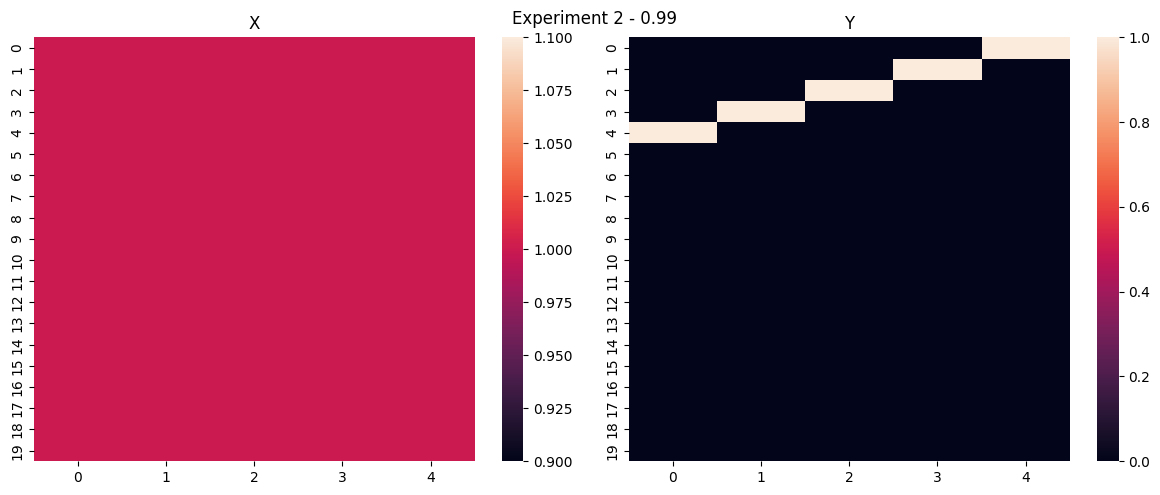

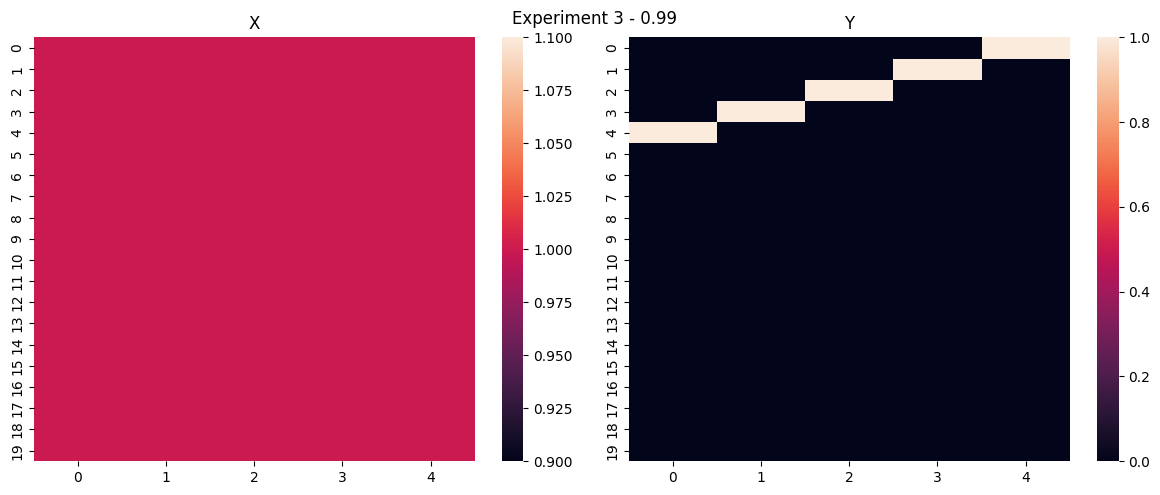

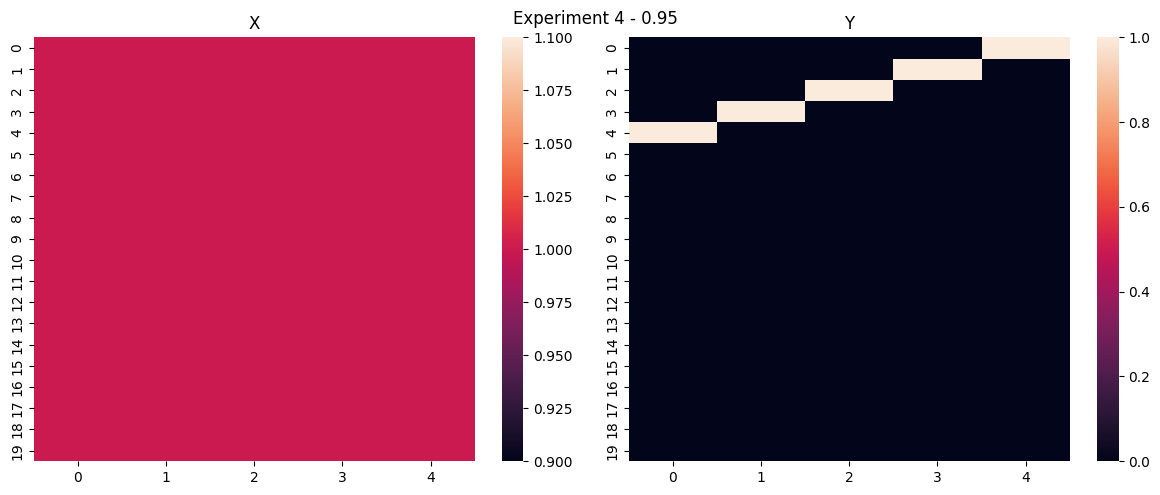

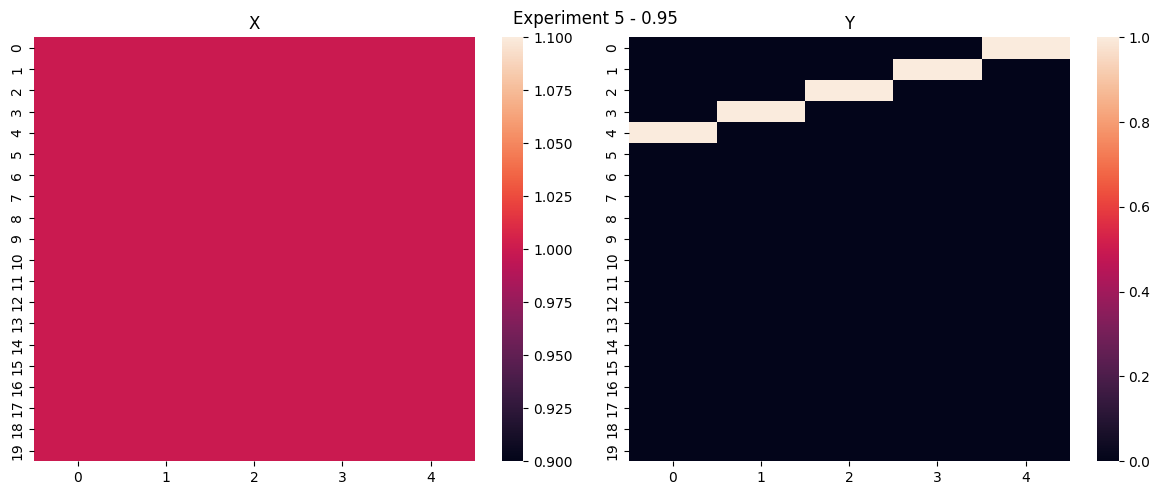

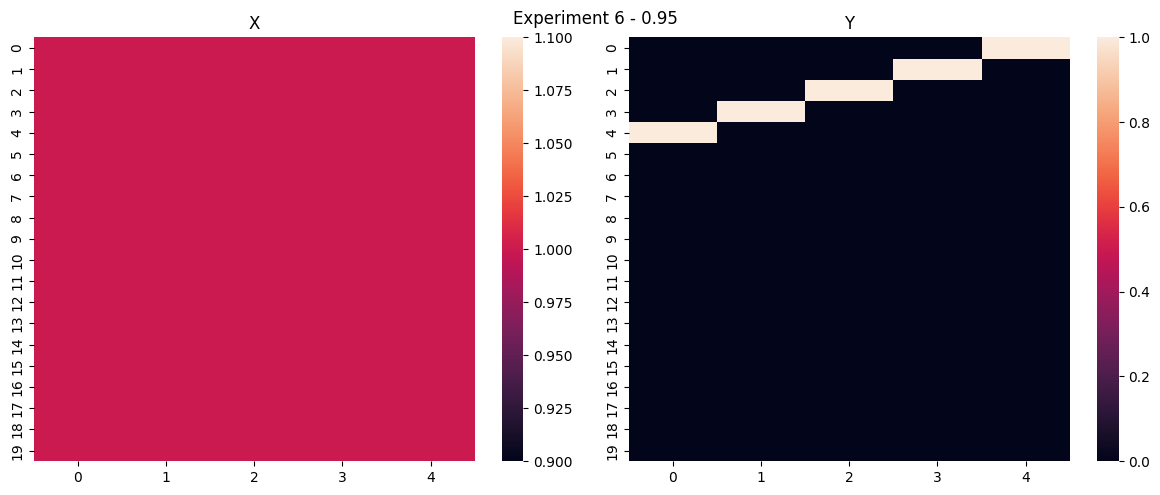

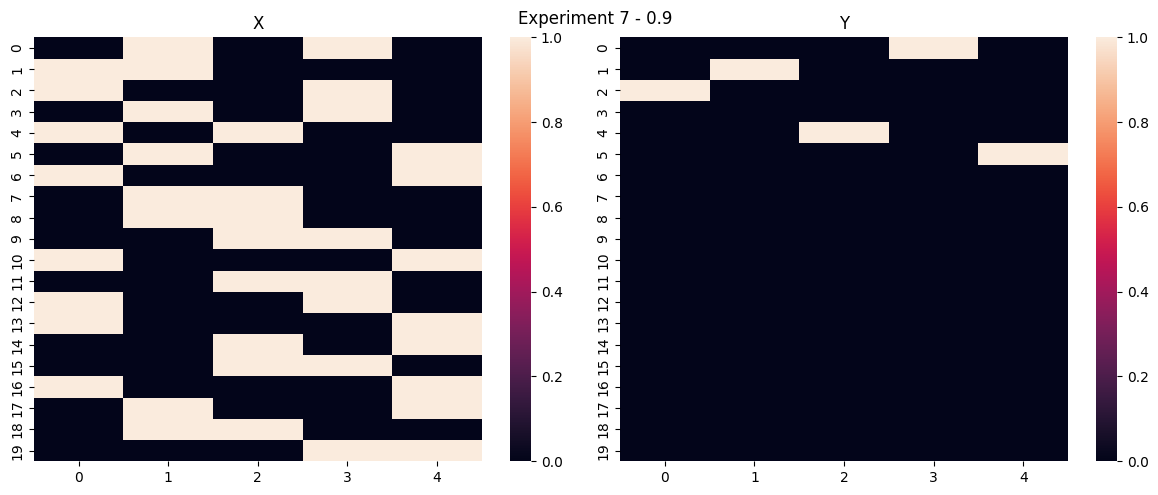

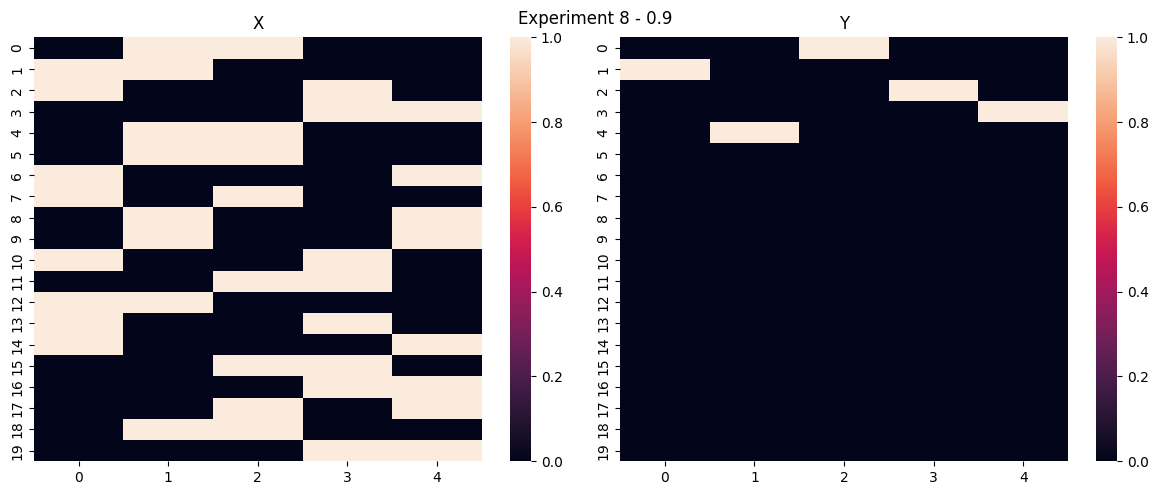

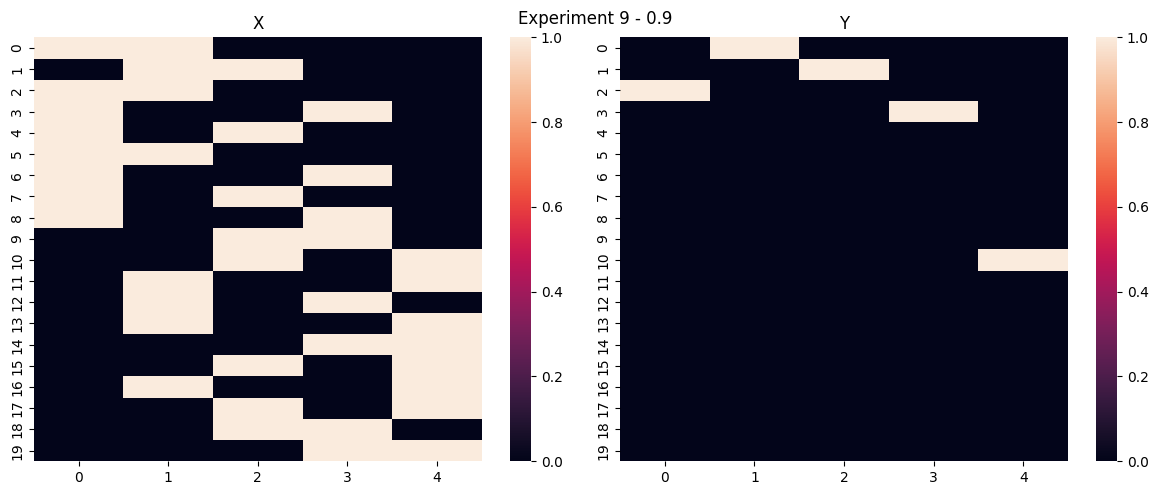

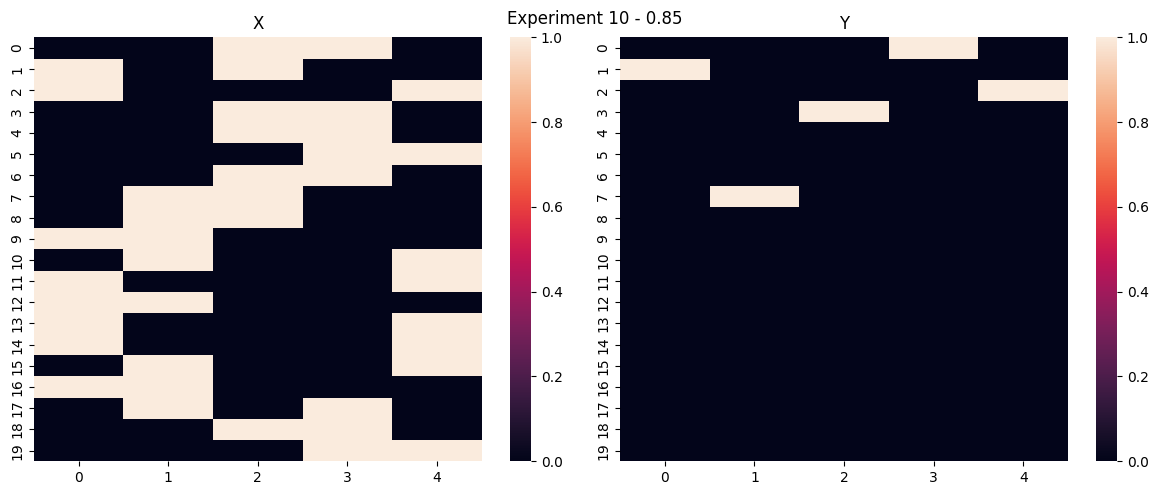

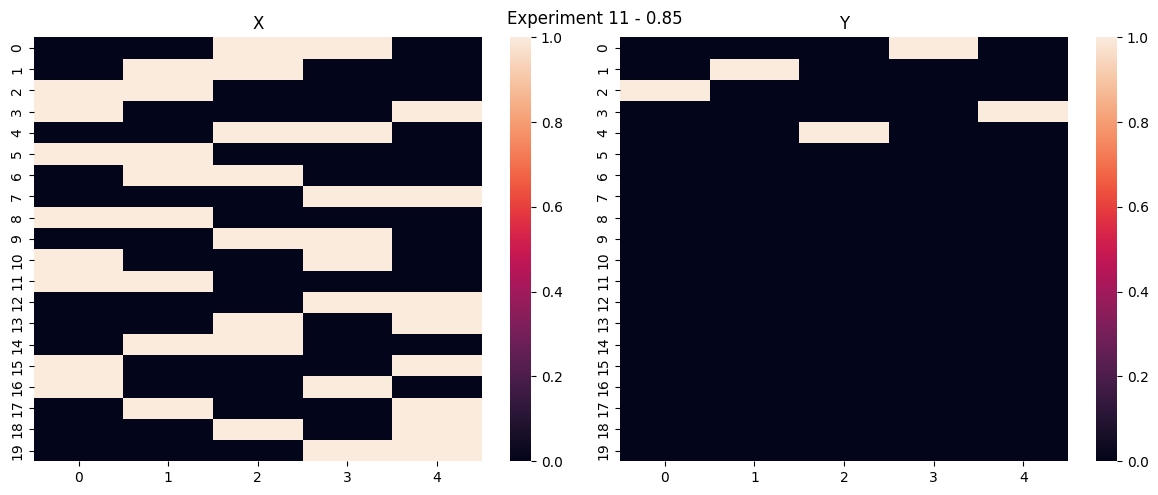

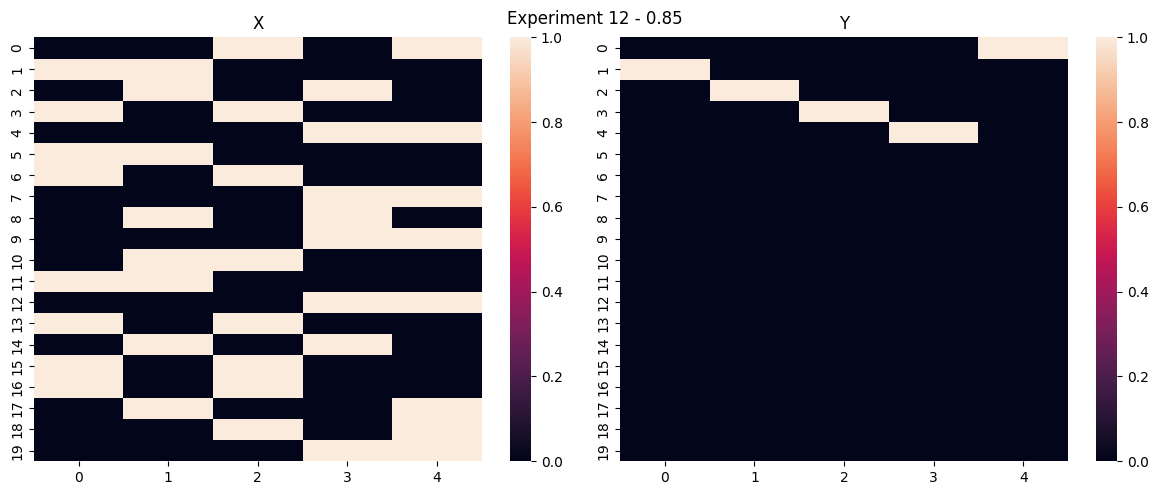

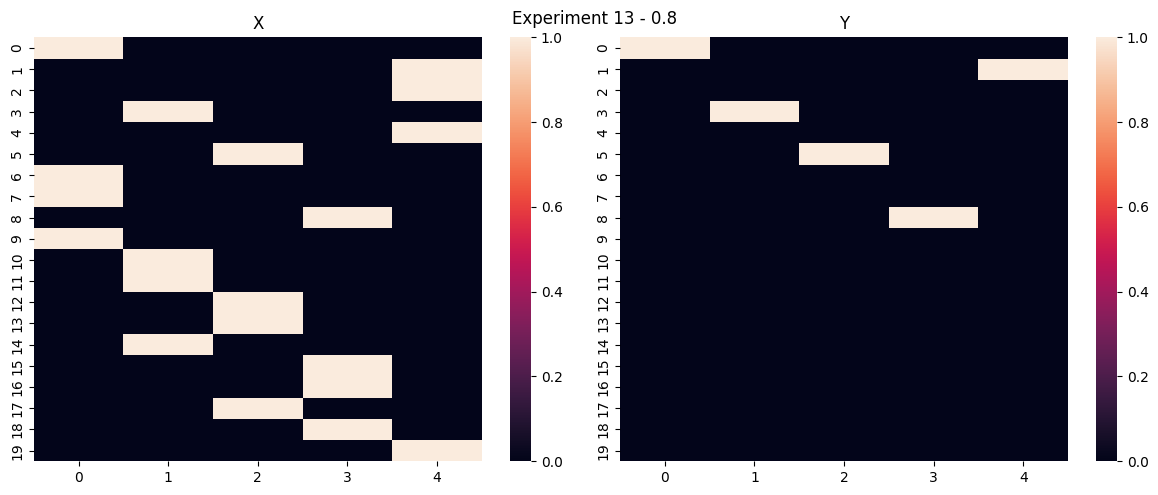

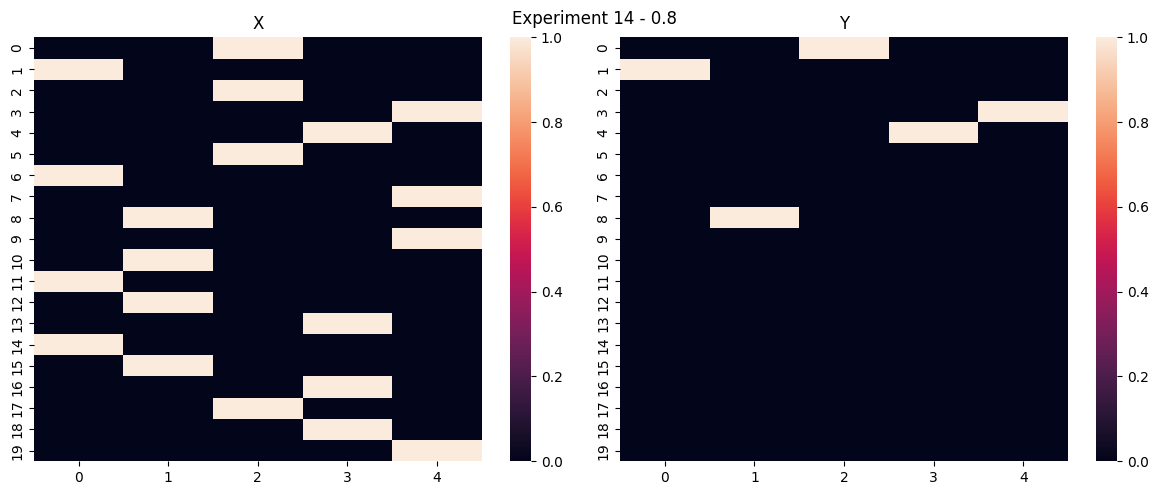

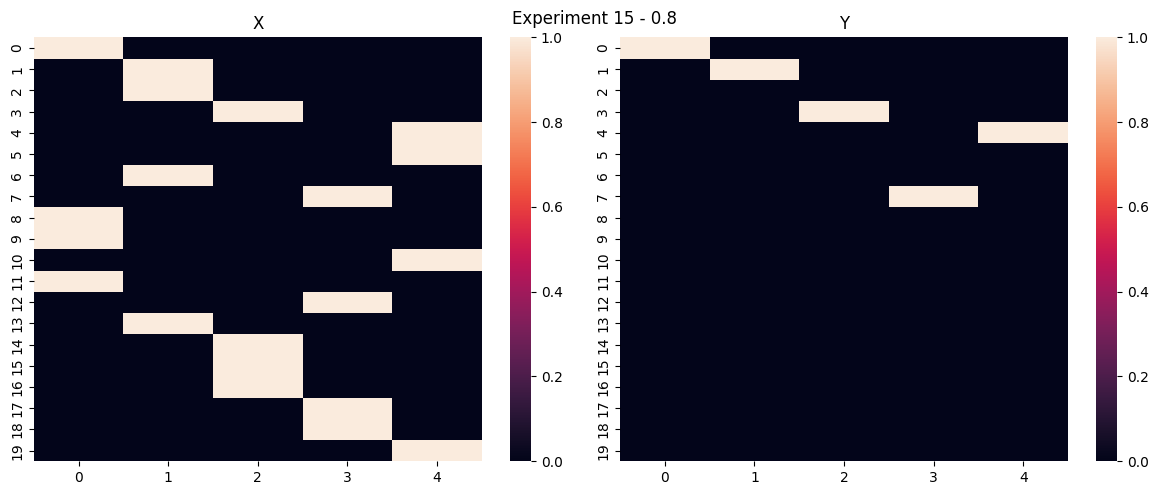

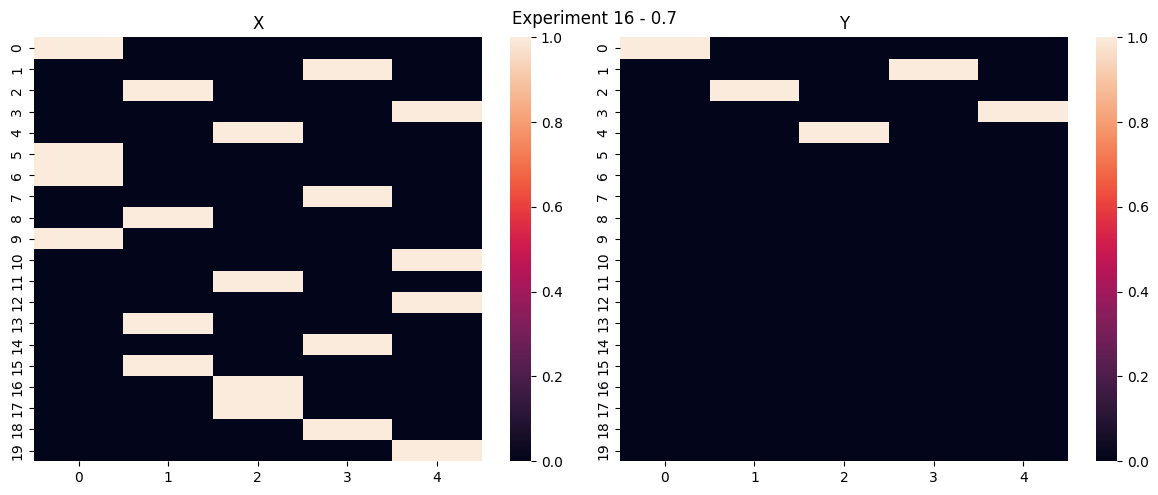

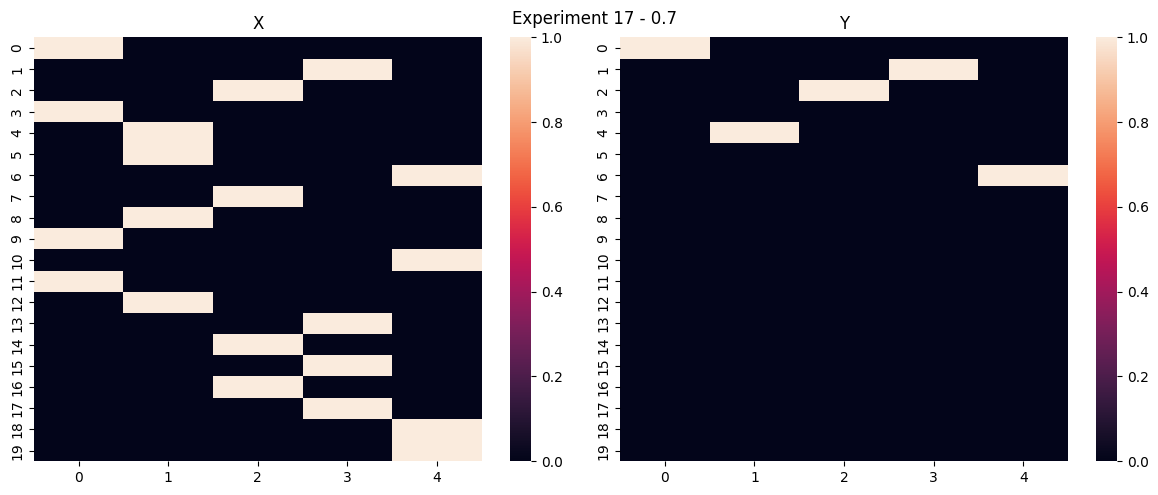

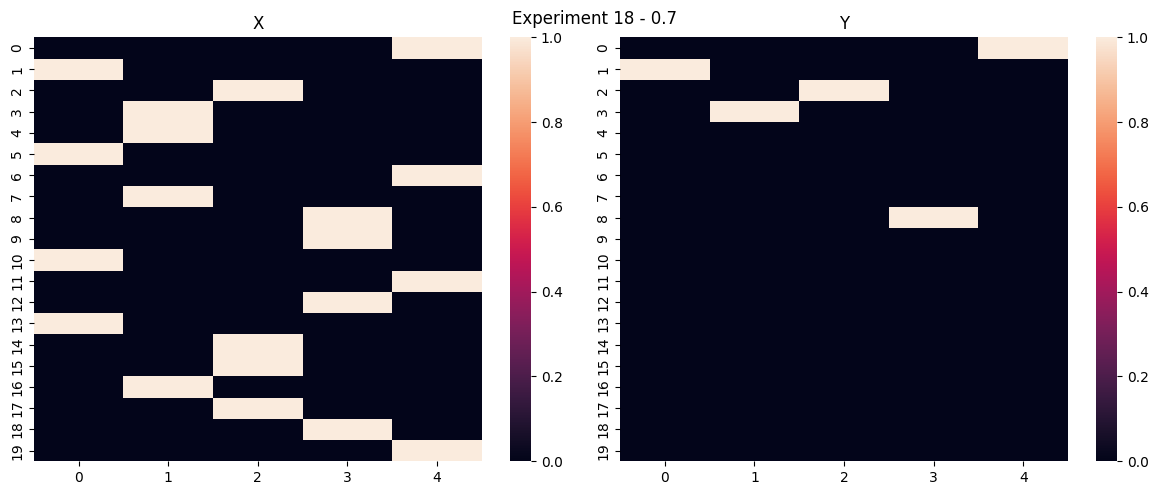

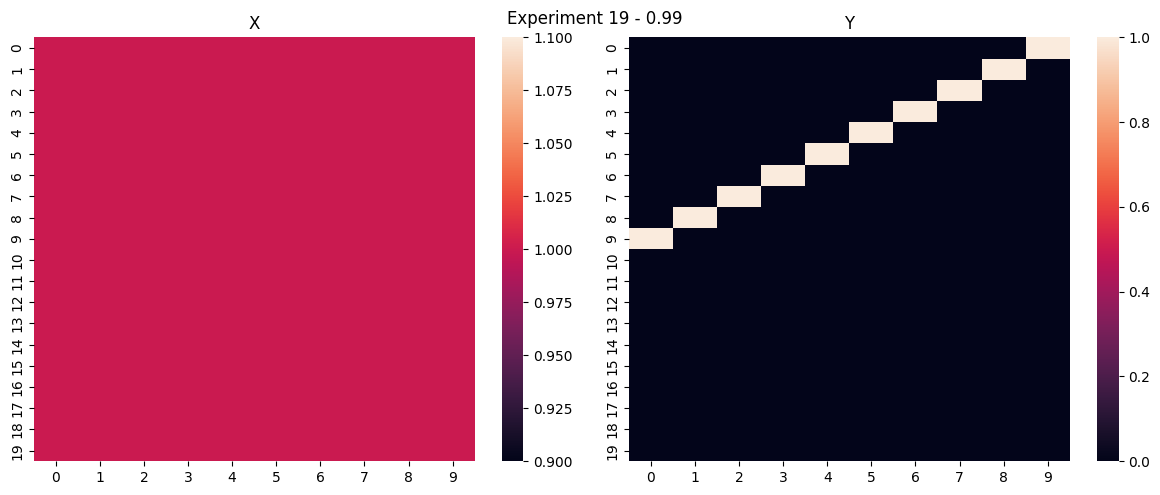

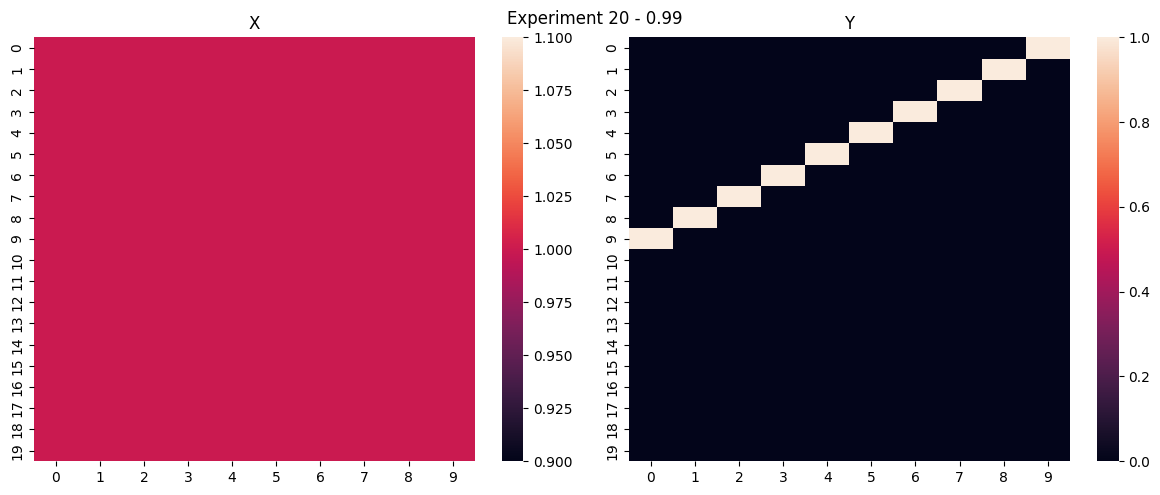

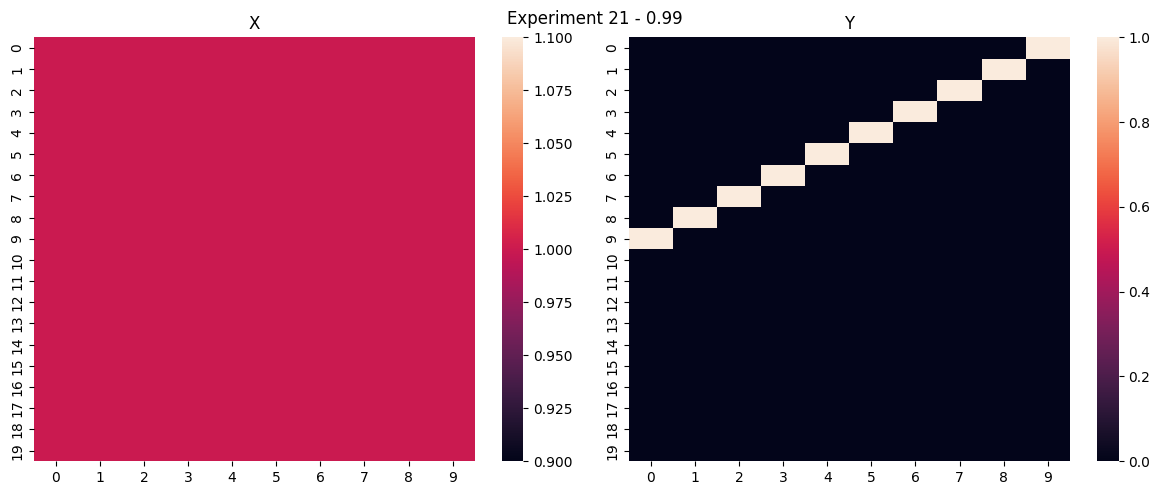

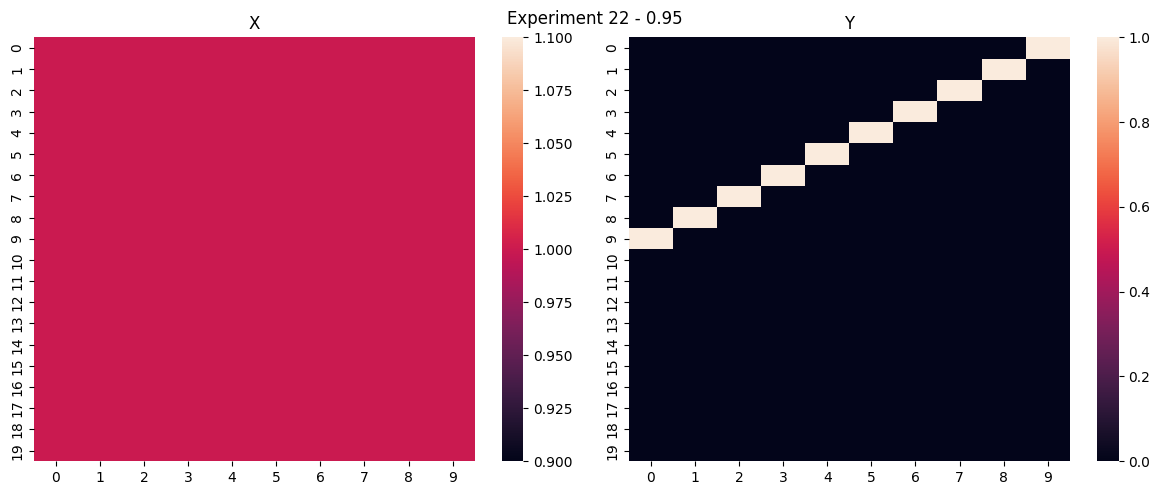

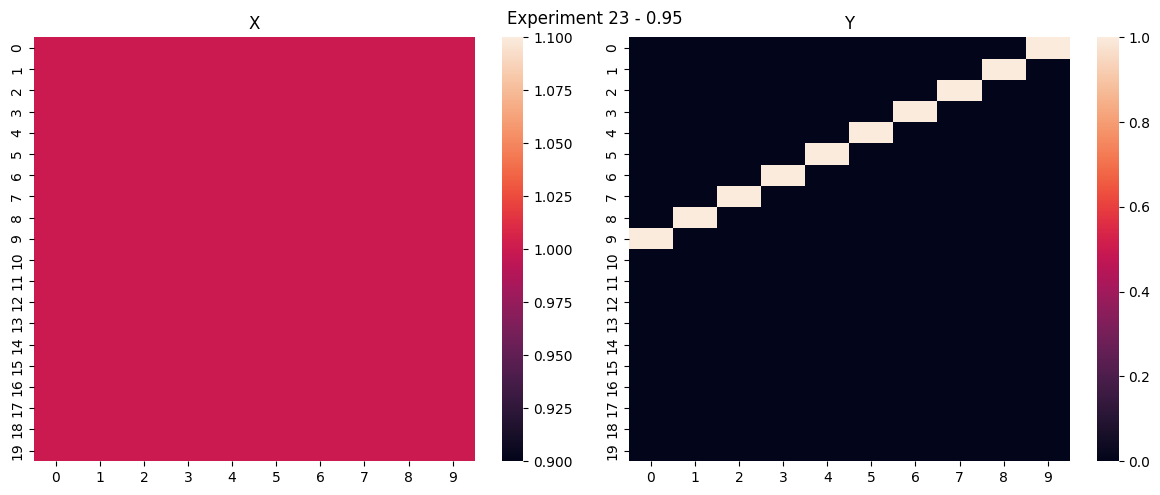

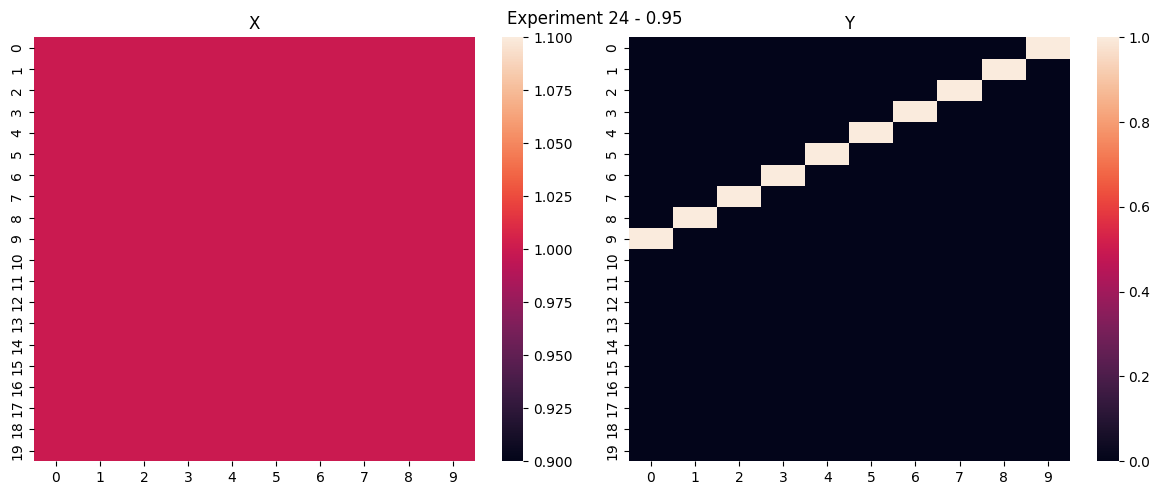

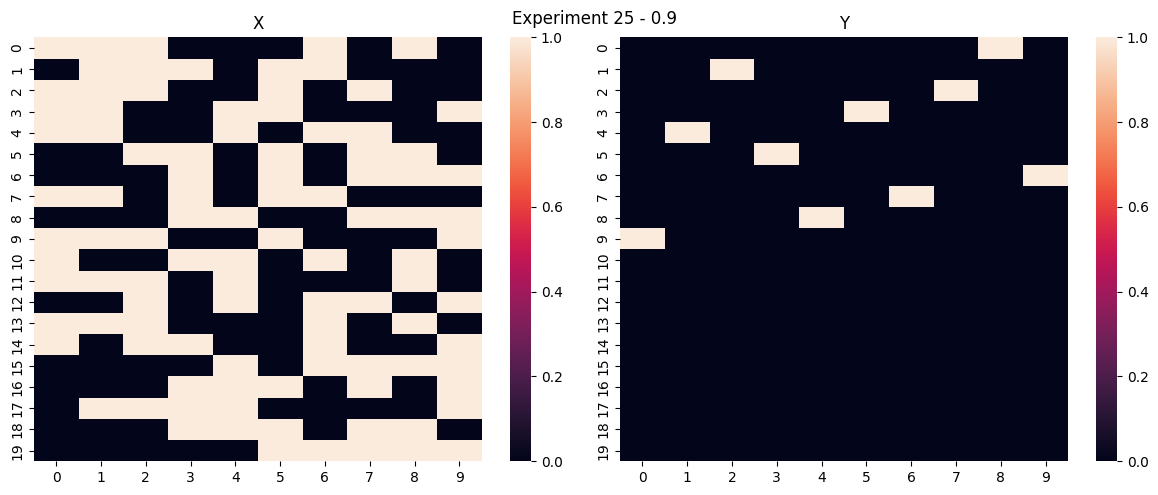

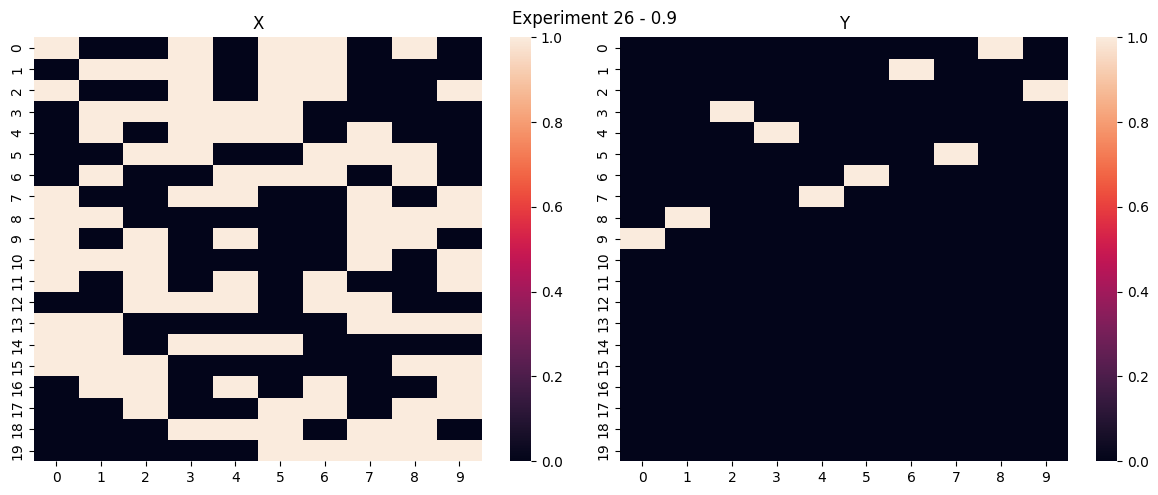

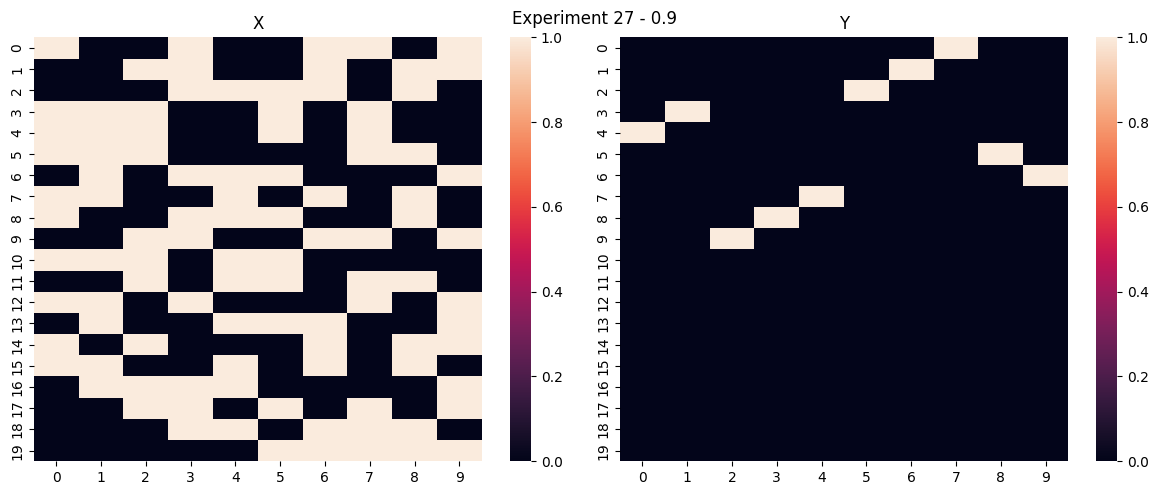

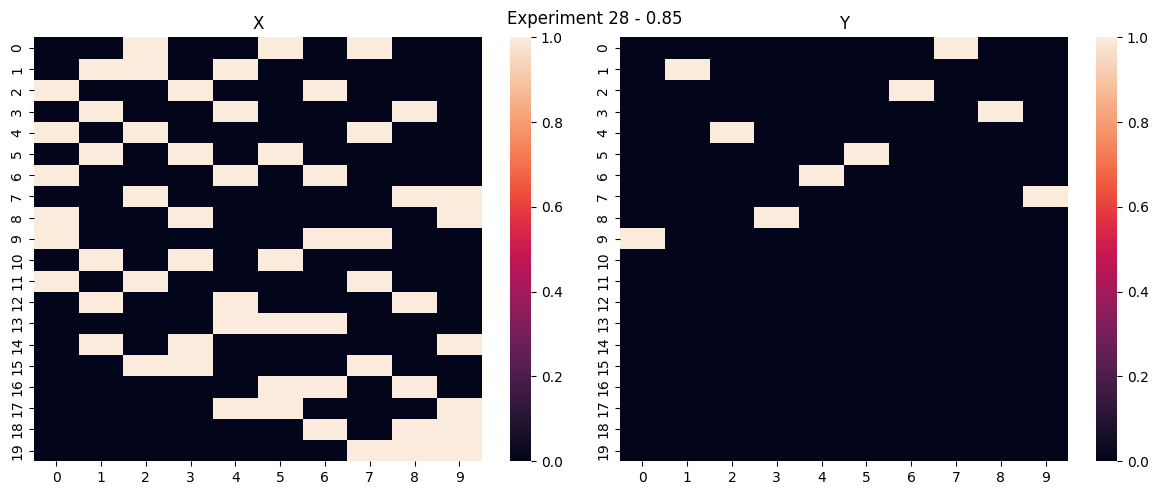

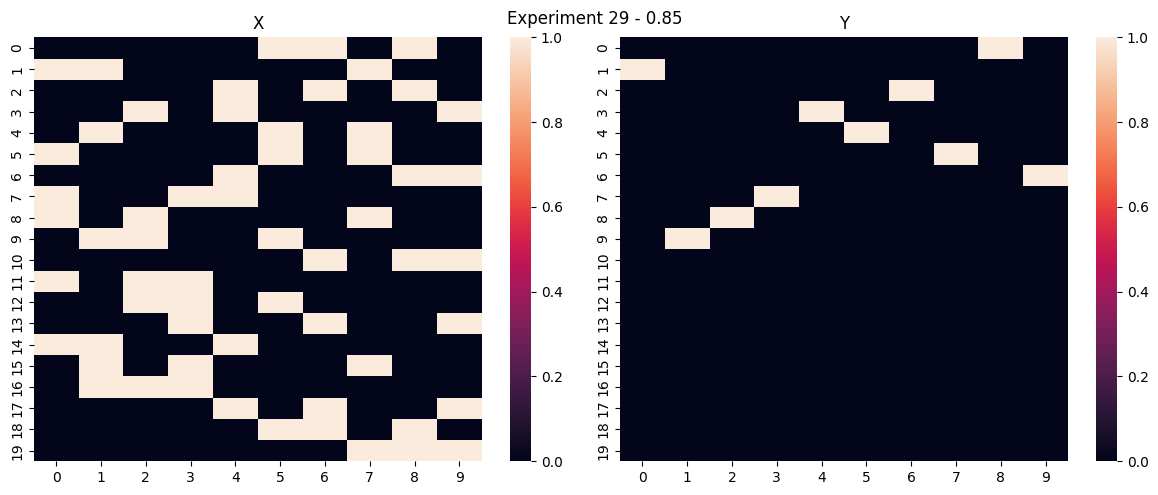

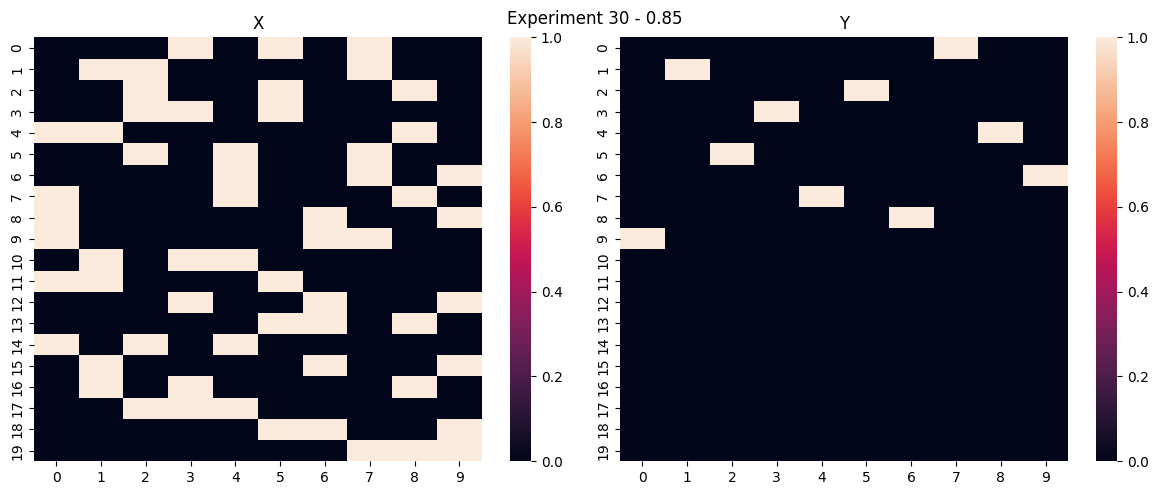

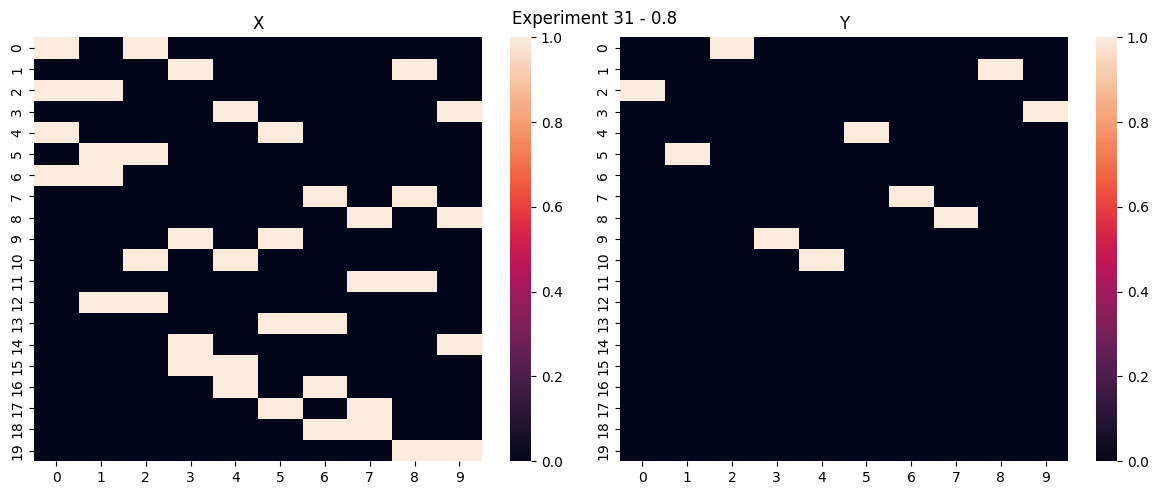

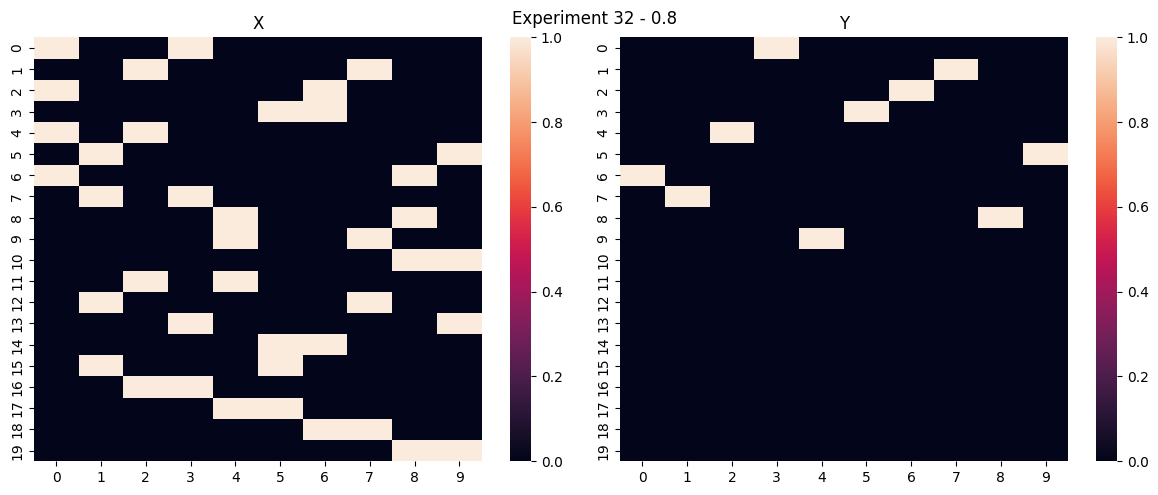

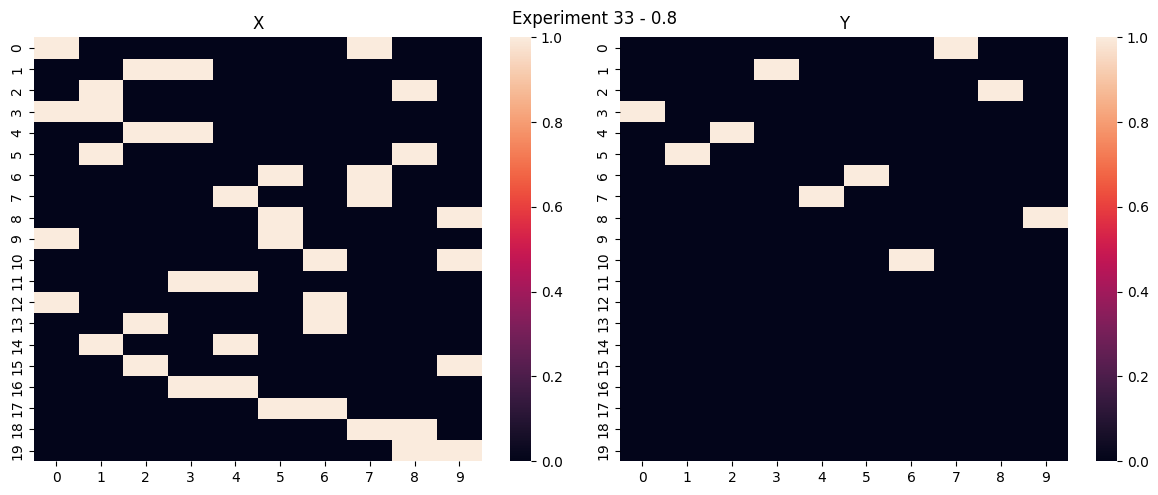

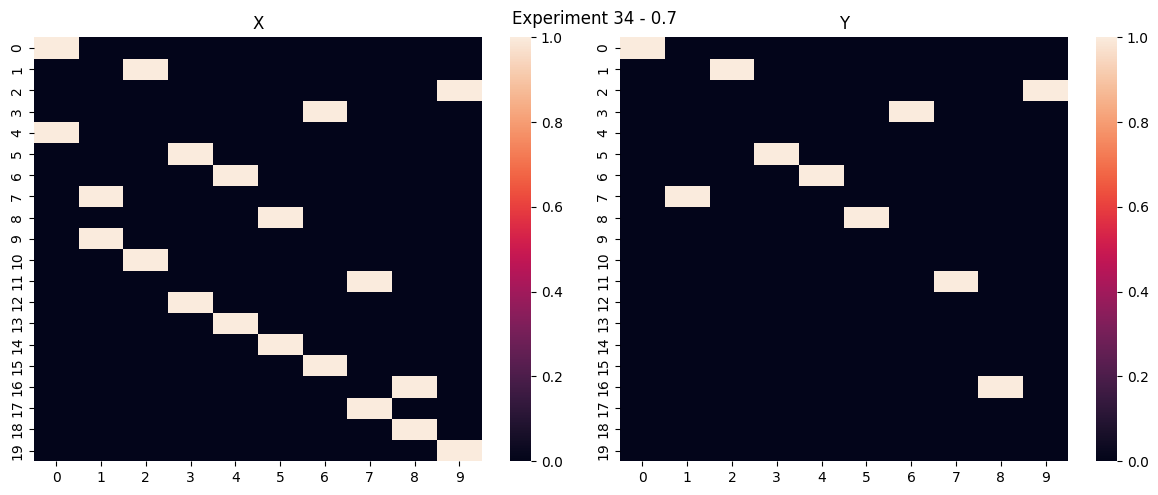

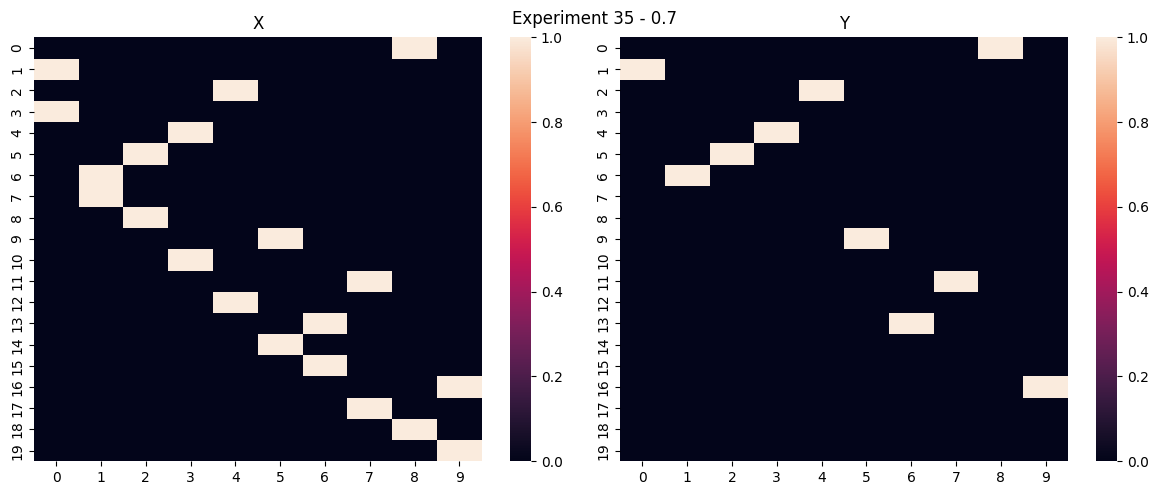

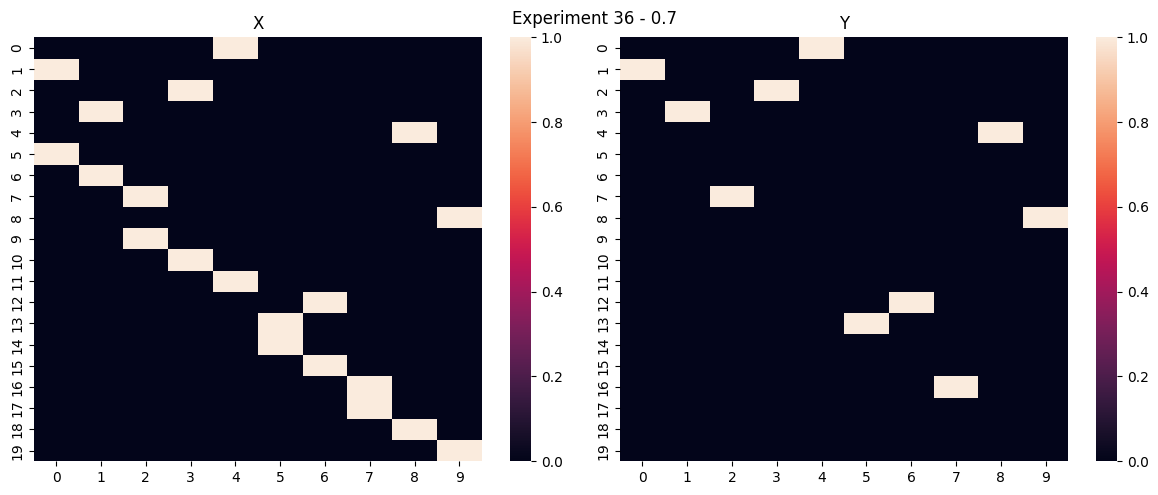

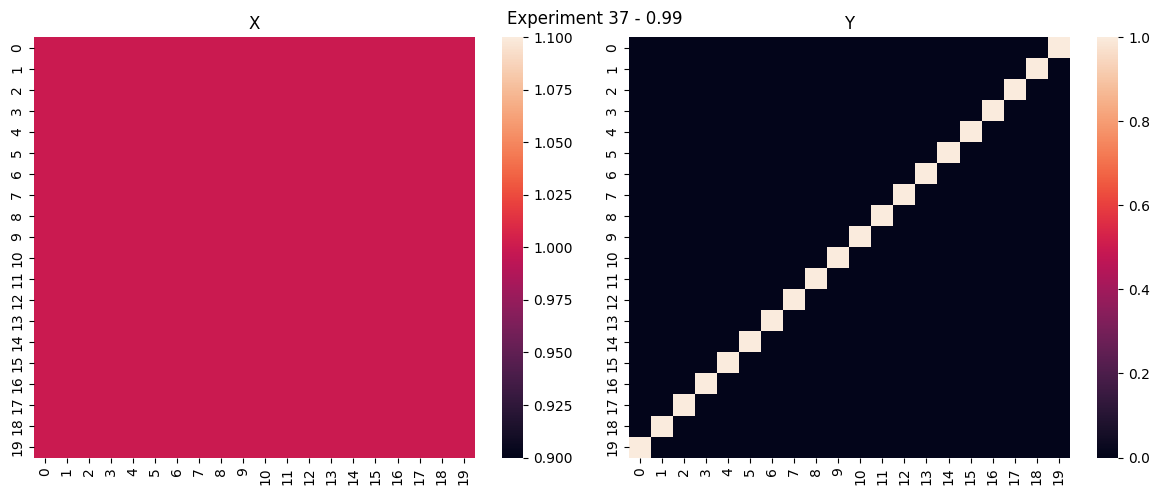

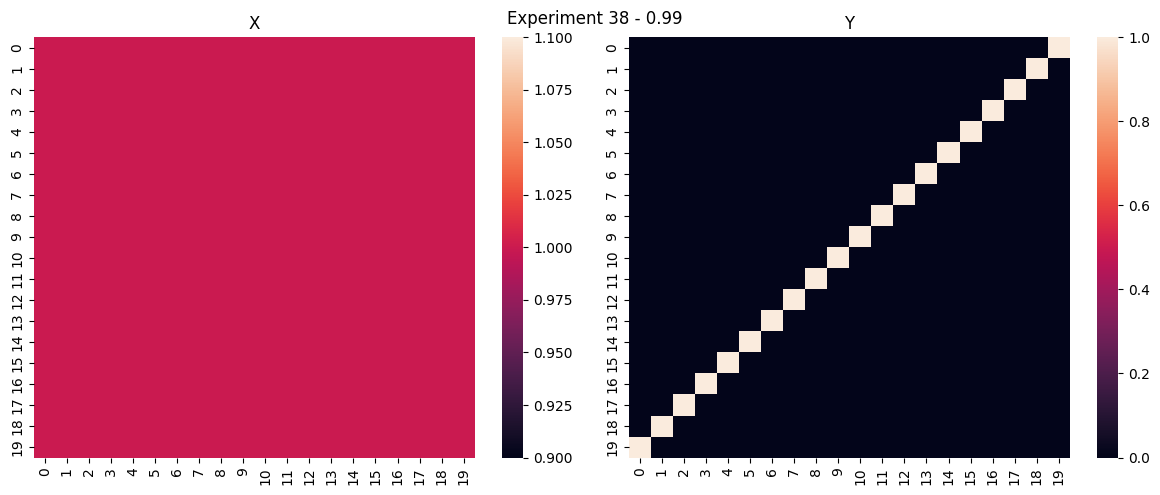

In [13]:


for i in range(len(exp)):
    plt.figure(figsize = (12,5), dpi=100)
    plt.subplot(1, 2, 1)
    sns.heatmap(exp[i]['results']['X'])
    plt.title('X')
    plt.subplot(1, 2, 2)
    sns.heatmap(Get_Y(exp[i]['results']['X']))
    plt.title('Y')
    plt.tight_layout()
    plt.suptitle('Experiment ' + str(i) + ' - ' + str(np.round(exp[i]['parameters']['p'],3)))
    plt.show()

